In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
def weight_init(experts,opening,method):
    #add market cap initialization
    if method == 'equal':
        w = np.ones(experts)
        w[opening.iloc[0]==0] = 0
        w[opening.iloc[0].isnull()] = 0
        return w

def losses(opening,closing,method):
    if method == 'absolute': #absolute return (close-open)
        return -1*(closing-opening)
    elif method=='pricerel': #price relative #closing over opening
        return -1*(closing/opening)
    elif method==3: #beta
        return 1

In [20]:
def mwu(filename,lossmethod,weightmethod):
    #data is a T by N matrix with each row being the returns of each expert i at time t
    data = pd.read_excel(filename)[::-1]
    opening = data.iloc[:,::2]
    closing = data.iloc[:,1::2]
    tickers = opening.columns
    dates = opening.index.values
    #print(dates)
    #return 0
#     returns = pd.DataFrame()
#     for i in range(len(opening.columns)):
#         tick = closing.iloc[:,i].name[:4]
#         returns[tick]=closing.iloc[:,i]-opening.iloc[:,i]
    
#     pricerel = pd.DataFrame()
#     for i in range(len(opening.columns)):
#         tick = closing.iloc[:,i].name[:4]
#         pricerel[tick]=closing.iloc[:,i]/opening.iloc[:,i]
    
    T = len(data)
    N = len(opening.columns)
    epsilon = np.sqrt(np.log(N)/T) 
   
    w = weight_init(N,opening,'equal')
    p = w/sum(w)
    
    start = 10000000
    #start_open = opening.iloc[0].values
    #return start_open
    #start_quant = []
    #for j,k in enumerate(start_open):
        #print(p[j]*start)
     #   if k == 0:
            #start_quant.append(0)
      #  elif p[j] != 0:
            #start_quant.append((p[j]*start)/k)
       # else:
        #    start_quant.append(0)
    #print(start_quant*start_open)

    quantities = [] #$/prices = quantity of each
    #return quantities

    probs = [p]
    values =[]
    transaction = []
    
    total = T-1 if (lossmethod=='pricerel') else T
    
    for t in range(total):
        #find new prices for the day
        #opening_prices_na = opening.iloc[t]
        #closing_prices_na = closing.iloc[t]
        if lossmethod=='absolute':
            opening_prices = opening.iloc[t].values
            opening_prices[opening.iloc[t].isnull()] = 0
            closing_prices = closing.iloc[t].values
            closing_prices[closing.iloc[t].isnull()] = 0
        elif lossmethod=='pricerel':
            opening_prices = opening.iloc[t-1].values
            opening_prices[opening.iloc[t-1].isnull()] = 0
            closing_prices = opening.iloc[t].values
            closing_prices[opening.iloc[t].isnull()] = 0
            
        if 0 not in opening_prices:
            w[w==0] = 1
    
        #return opening_prices
        
        #portfolio value
        if t==0: 
            values.append(start)
        else:
            values.append(np.sum(np.array(opening_prices)*np.array(quantities[t-1]))) #new opening value
        
        q_t = []
        for j,k in enumerate(opening_prices):
            if k == 0:
                q_t.append(0)
            elif p[j] != 0:
                q_t.append((p[j]*values[t])/k)
            else:
                q_t.append(0)
        quantities.append(q_t)

        loss = losses(opening_prices,closing_prices,lossmethod) 
        loss[np.isnan(loss)] = 0
        M = max(abs(loss))
        loss = losses(opening_prices,closing_prices,lossmethod)/M
        loss[np.isnan(loss)] = 0
                
        #check sum of weight updates
        money_moved = sum(np.absolute([-p[i]*epsilon*loss[i] for i in range(N)]))*values[t]
        
        if t==0 or values[t]-values[t-1] >= 0.015*money_moved:
            for i in range(N):
                w[i] = w[i]*(1-epsilon*loss[i])
            transaction.append((t,0.015*money_moved))
        #print(w,transaction)
        
       
        p = w/sum(w)
        probs.append(p)
        #return p

        
    if lossmethod=='pricerel':
        out = pd.DataFrame(probs[1:],columns=tickers,index=dates[:-1])
    elif lossmethod=='absolute':
        out = pd.DataFrame(probs[1:],columns=tickers,index=dates)
    #print(out)
    out['Values'] = values
    out.to_csv(f'weights_return_{weightmethod}_{lossmethod}_{filename[:-5]}.csv')
    print('Final distribution: ',p)
    print('Final transaction count: ',len(transaction),'total cost: ',sum([v[1] for v in transaction]))
    print('starting value: ',start,'final value: ',values[-1],'less transaction costs: ',values[-1]-sum([v[1] for v in transaction]))
    #np.savetxt('q_lv_w.csv',quantities,delimiter=',')
    plt.plot(values)
    plt.show()
    return values

In [18]:
#data = pd.read_excel('lowvol_weekly.xlsx')[::-1]
filename = 'lowvol_weekly.xlsx'

Final distribution:  [0.05247597 0.05121712 0.05338635 0.0505242  0.05158649 0.05291083
 0.05245808 0.05234551 0.05283828 0.05332507 0.05574567 0.05236053
 0.05273846 0.0514674  0.05426938 0.05345839 0.05389122 0.05347635
 0.0495247 ]
Final transaction count:  365 total cost:  7006129.441877285
starting value:  10000000 final value:  34953240.512126215 less transaction costs:  27947111.07024893


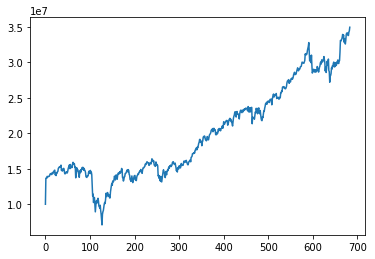

[10000000,
 13677906.639644818,
 13669471.796664607,
 13658996.901978508,
 13931829.931985969,
 13822598.446662687,
 13898798.3354408,
 13940937.617285073,
 13923562.684273591,
 13965507.351388821,
 14132421.895400336,
 14311633.171548089,
 14214350.058003185,
 14350960.505267322,
 14181941.383904424,
 14407450.718511432,
 14364565.428267242,
 14321838.368393643,
 14607329.925413754,
 14514161.341799544,
 14776015.890172642,
 14806577.854388095,
 14146190.608448453,
 14346174.41249513,
 14045028.143002339,
 14401608.324590378,
 14388237.667609394,
 14594181.933947416,
 14632112.970580908,
 15073636.104387756,
 15125107.735356312,
 15257765.334895313,
 15191437.003086815,
 15310953.7862048,
 15327671.22536555,
 15514190.186244147,
 14769982.986774465,
 14997443.244169135,
 14675425.278893568,
 14783177.596499354,
 14941899.871416979,
 15062710.010244586,
 14853806.101221912,
 14410647.020098213,
 14274255.066036819,
 14402721.770737711,
 14463801.473667733,
 14585020.463979851,
 1441714

In [21]:
mwu(filename,'pricerel','equal')

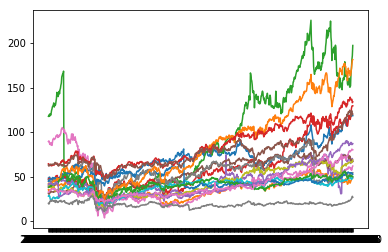

In [75]:
opening = pd.read_excel('lowvol_weekly.xlsx')[::-1].iloc[:,::2]
opening = opening.drop(['BRK.B_open'], axis=1)
plt.plot(opening)
plt.show()

In [82]:
d = (opening.iloc[-1] - opening.iloc[0])/opening.iloc[0]
d

WMT_open    1.457979
BK_open     0.377230
CI_open     0.676548
JPM_open    1.764831
DD_open     0.730868
CL_open     1.146506
HIG_open   -0.308501
AFL_open    0.180849
DOX_open    0.710112
BCE_open    0.731263
KO_open     0.182492
HON_open    3.316916
L_open      0.320655
PEP_open    1.083981
RSG_open    1.130382
PG_open     0.915419
SYY_open    1.458423
WU_open     0.341206
dtype: float64